# Preparation

In [2]:
%load_ext ipycache
import iminuit
%load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing
import numba
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_style('darkgrid')
sns.set_context('notebook')

The ipycache extension is already loaded. To reload it, use:
  %reload_ext ipycache
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [3]:
results = pd.DataFrame()

In [4]:
def corrfunc(x, y, **kws):
    r, p = sp.stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(f"\u03C1 = {r:.2f}\np = {p:.2f}", #unicode code for lowercase rho (ρ)
                xy=(.1, .9), xycoords=ax.transAxes)

# Load C14 models

In [5]:
import c14_models

# Read patient data

In [6]:
exp_data = pd.read_pickle('../../../results/C14data_liver_samples_20191023.pkl')
# exp_data['type'] = pd.Categorical(exp_data['type'])

In [7]:
exp_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,e14C,N_cells,pathology,sex,subject_age,ploidy
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,0.003981,NaN,N,F,73.583333,2n4n
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,0.003912,NaN,N,M,25.416667,2n4n
2,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,0.004711,62.0,N,M,58.333333,2n4n
3,hepatocyte,PH7,ND023,1945.833333,2004.833333,0.090351,0.004395,70.0,N,M,59.000000,2n4n
4,hepatocyte,PH11,ND375,1992.500000,2016.333333,0.003700,0.016000,61.0,N,M,23.833333,2n4n


In [8]:
exp_data.describe()

,Dbirth,Dcoll,d14C,e14C,N_cells,subject_age
count,101.000000,101.000000,101.000000,101.000000,68.000000,101.000000
mean,1961.601485,2015.985149,0.044854,0.007311,62.286765,54.383663
std,18.230010,3.407373,0.026707,0.003548,29.220893,18.267857
min,1932.583333,2004.833333,0.003700,0.002300,12.000000,20.000000
25%,1946.500000,2016.666667,0.026300,0.004711,41.000000,39.083333
50%,1959.416667,2017.250000,0.039600,0.006450,61.500000,57.833333
75%,1975.333333,2017.500000,0.064400,0.009000,73.500000,66.000000
max,1997.333333,2019.750000,0.131107,0.021571,135.000000,84.666667


# Plot data 

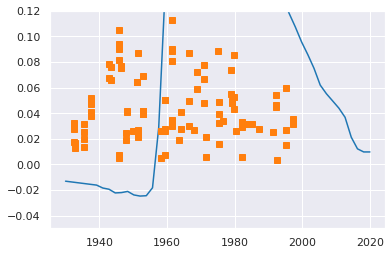

In [9]:
tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(c14_models.C_atm)(tt))
plt.plot(exp_data['Dbirth'], exp_data['d14C'], ls = 'None', marker = 's')
plt.ylim(-0.05, 0.12)
plt.show()

# Individual rates

In [10]:
@np.vectorize
def I1(Dbirth, Dcoll, loglam):
    """ For very high turnover rates return the atmospheric C14 concentration
        at the date of collection to avoid lengthy computations.
    """
    if loglam <= 10:
        lam = np.exp(loglam)
        return c14_models.I1(Dbirth, Dcoll, lam, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]
    else:
        return c14_models.C_atm(Dcoll)

def diffI1(loglam, data):
    model_data = I1(data['Dbirth'], 
                    data['Dcoll'], 
                    loglam)
    diff = (model_data - data['d14C'])
    return diff

def SSE_individual(p, data):
    model_data = I1(data['Dbirth'], 
                    data['Dcoll'], 
                    p)
    sse = np.sum((model_data - data['d14C'])**2)
    return sse    

def plot_diffI1(loglammin, loglammax, data):
    loglams = np.linspace(loglammin, loglammax)
    diff = np.vectorize(diffI1, excluded=[1])(loglams, data)
    plt.title(data['code'])
    plt.plot(loglams, diff, label='Diff predicted to measured')
    plt.plot([loglammin, loglammax], [0, 0], color='black')

def individual_rate(i, loglam0=np.log(0.1)):
    try:
#         return np.exp(sp.optimize.brentq(diffI1, -8, 10, args=exp_data.iloc[i]))
        return np.exp(sp.optimize.newton(diffI1, loglam0, args=([exp_data.iloc[i]])))
    except:
        return np.nan
    
def individual_rate_SSE(i, loglam0=np.log(0.1)):
    r = np.exp(
            sp.optimize.minimize(
                SSE_individual, loglam0, args=(exp_data.iloc[i]), method='Nelder-Mead'
            )['x'][0]
        )
    return r

In [11]:
p=multiprocessing.Pool(processes=7)

In [12]:
exp_data['individual_rate_SSE'] = p.map(individual_rate_SSE, range(len(exp_data)))

In [13]:
exp_data['individual_rate_newton'] = p.map(individual_rate, range(len(exp_data)))

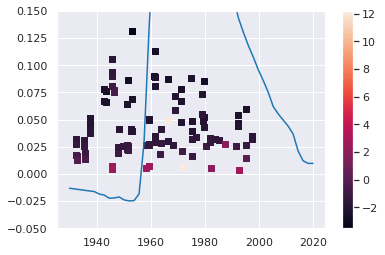

In [14]:
tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(c14_models.C_atm)(tt))
plt.scatter(exp_data['Dbirth'], exp_data['d14C'], marker='s', c=np.log(exp_data['individual_rate_SSE']))
plt.colorbar()
plt.ylim(-0.05, 0.15)
plt.show()

# Compare to graphical solution

In [15]:
# %%cache -d ipycache graphical.pkl
# fig, axs = plt.subplots(int(np.ceil(len(exp_data)/8)), 8, sharex=True, sharey=True, figsize=(8.3, 11.7))

# for ax in axs[-1]:
#     ax.set_xlabel(u'λ')
# for ax in axs[:,0]:
#     ax.set_ylabel(u'ΔC14')
    
# axs = axs.flatten()
# loglammin, loglammax = -10, 5
# loglams = np.linspace(loglammin, loglammax)
# for (i, data), ax in zip(exp_data.iterrows(), axs):
#     diff = np.vectorize(diffI1, excluded=[1])(loglams, data)
#     ax.set_title(data['code'])
#     ax.plot(loglams, diff, label='Diff predicted to measured')
#     ax.axhline(0, color='black')
#     ax.axvline(np.log(data['individual_rate_SSE']), color='black')
    
# ax.set_xlim(loglammin, loglammax)
# ax.set_ylim(-0.07, 0.07)
# plt.tight_layout()
# plt.savefig('../../results/plots/individual_rate_solution.pdf', dpi=300, bbox_inches='tight')
# plt.show()

# Plot rates

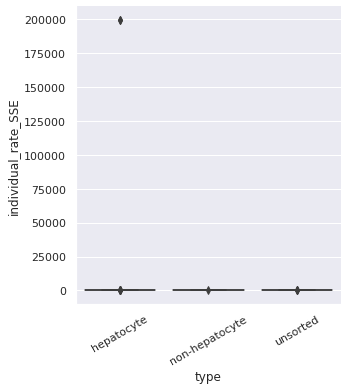

In [16]:
ax = sns.catplot(data=exp_data, x='type', y='individual_rate_SSE', kind='box')
ax.set_xticklabels(rotation=30)
plt.show()

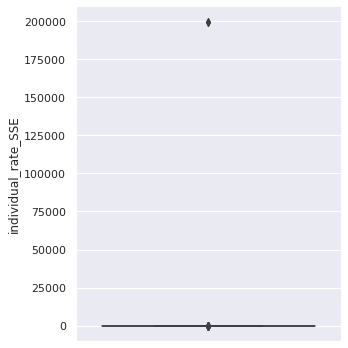

In [17]:
ax = sns.catplot(data=exp_data,  y='individual_rate_SSE', kind='box')
plt.show()

# Detect outliers based on IQR

In [18]:
# Computing IQR
Q1 = exp_data['individual_rate_SSE'].quantile(0.25)
Q3 = exp_data['individual_rate_SSE'].quantile(0.75)
IQR = Q3 - Q1

# Selecting Values between Q1-1.5IQR and Q3+1.5IQR
exp_data['rate_is_not_outlier'] = exp_data.eval('(@Q1 - 1.5 * @IQR) <= individual_rate_SSE <= (@Q3 + 1.5 * @IQR)')

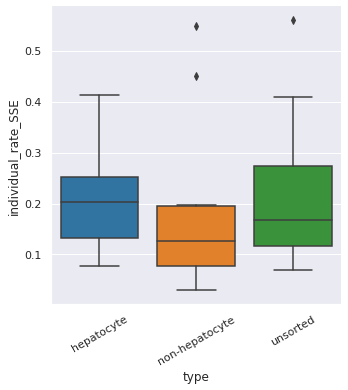

In [19]:
ax = sns.catplot(data=exp_data.query('rate_is_not_outlier'), x='type', y='individual_rate_SSE', kind='box')
# sns.swarmplot(data=exp_data, x='type', y='individual_rate_SSE', color='black', size=2)
ax.set_xticklabels(rotation=30)
plt.show()

# Sanity check of the results by comparing the two methods:

In [20]:
exp_data.query('rate_is_not_outlier').query('(individual_rate_SSE - individual_rate_newton)**2 > (1e-3)**2')

,type,code,sample,Dbirth,Dcoll,d14C,e14C,N_cells,pathology,sex,subject_age,ploidy,individual_rate_SSE,individual_rate_newton,rate_is_not_outlier


# Analysing results

I use the values obtained with SSE

In [21]:
exp_data['cell_age'] = 1. / exp_data['individual_rate_SSE']

In [28]:
exp_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,e14C,N_cells,pathology,sex,subject_age,ploidy,individual_rate_SSE,individual_rate_newton,rate_is_not_outlier,cell_age
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,0.003981,NaN,N,F,73.583333,2n4n,0.087163,0.087162,True,11.472762
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,0.003912,NaN,N,M,25.416667,2n4n,0.346924,0.346928,True,2.882476
2,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,0.004711,62.0,N,M,58.333333,2n4n,0.707508,0.707507,False,1.413411
3,hepatocyte,PH7,ND023,1945.833333,2004.833333,0.090351,0.004395,70.0,N,M,59.000000,2n4n,0.259441,0.259438,True,3.854446
4,hepatocyte,PH11,ND375,1992.500000,2016.333333,0.003700,0.016000,61.0,N,M,23.833333,2n4n,15.426992,NaN,False,0.064821


In [32]:
exp_data = exp_data[exp_data['ploidy'] == '4n'].query('pathology in ["N", "T"]')

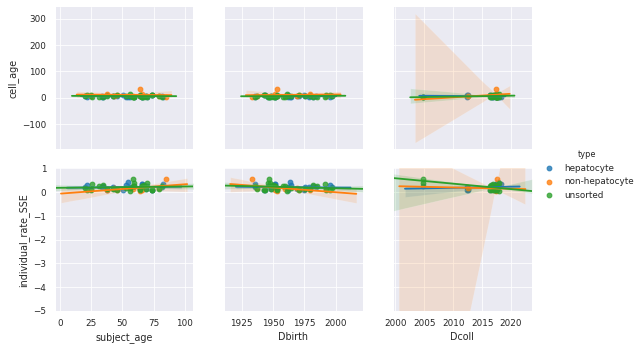

In [35]:
sns.pairplot(exp_data.query('rate_is_not_outlier'),
            x_vars = ['subject_age', 'Dbirth', 'Dcoll'],
            y_vars = ['cell_age', 'individual_rate_SSE'],
             kind='reg',
            hue = 'type')
plt.ylim(-5, 1)
plt.show()

In [ ]:
sns.pairplot(exp_data.query('rate_is_not_outlier'),
            x_vars = ['subject_age', 'Dbirth', 'Dcoll'],
            y_vars = ['cell_age', 'individual_rate_SSE'],
             kind='reg',
            hue = 'type')
plt.show()

# Plot for Olaf

## Rate

In [36]:
plot_data = exp_data.query('rate_is_not_outlier').query('type in ["hepatocyte", "non-hepatocyte", "unsorted"]')

In [37]:
plot_data['type'].cat.remove_unused_categories(inplace=True)

In [38]:
sns.set_context('paper')

FileNotFoundError: [Errno 2] No such file or directory: '../../results/plots/individual_rate_age.pdf'

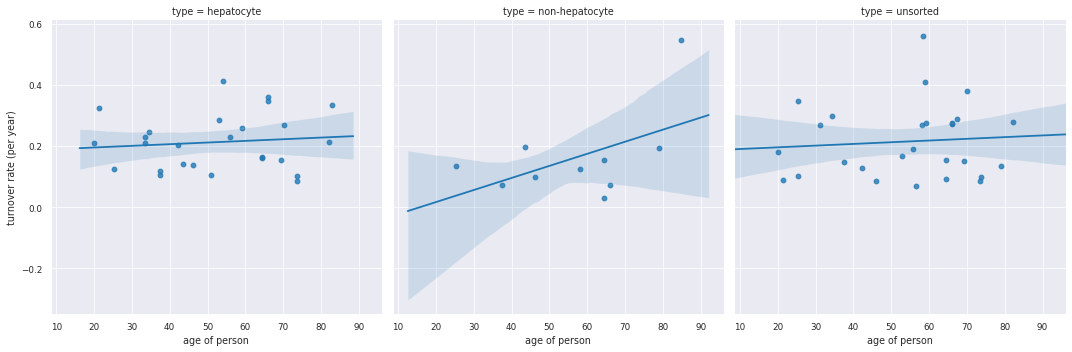

In [39]:
ax = sns.lmplot(x='subject_age', y='individual_rate_SSE', col='type', data=plot_data,
                col_order=['hepatocyte', 'non-hepatocyte', 'unsorted'])
ax.set_axis_labels(x_var='age of person', y_var='turnover rate (per year)')
plt.savefig('../../results/plots/individual_rate_age.pdf', dpi=300, bbox_inches='tight')
plt.show()

No significant correlation in the above data:

In [ ]:
plot_data.groupby('type').apply(lambda g: pd.Series({key: value for key, value in zip(['r', 'p'],
    sp.stats.pearsonr(g['subject_age'], g['individual_rate_SSE']))}))

In [ ]:
plot_data.groupby('type').apply(lambda g: smf.ols('individual_rate_SSE ~ subject_age', data=g).fit().params)

## Cell Age

In [ ]:
ax = sns.lmplot(x='subject_age', y='cell_age', col='type', data=plot_data,
               col_order=['hepatocyte', 'non-hepatocyte', 'unsorted'])
ax.set_axis_labels(x_var='age of person', y_var='average cell age (years)')
plt.savefig('../../results/plots/individual_rate_age.pdf', dpi=300, bbox_inches='tight')
plt.show()

No significant correlation in the above data:

In [ ]:
plot_data.groupby('type').apply(lambda g: pd.Series({key: value for key, value in zip(['r', 'p'],
    sp.stats.pearsonr(g['subject_age'], g['cell_age']))}))

In [ ]:
plot_data.groupby('type').apply(lambda g: smf.ols('cell_age ~ subject_age', data=g).fit().params)

# Export

In [ ]:
exp_data.to_excel('../../results/cell_age.xlsx')

In [ ]:
exp_data.query('rate_is_not_outlier and (type == "hepatocyte")').mean()